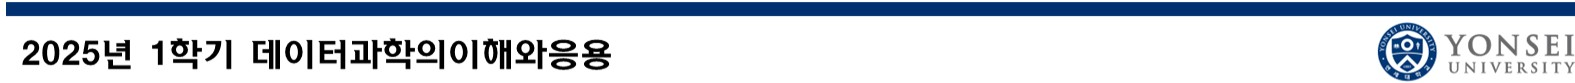

### 주어진 데이터는 생활 습관에 따른 행복도 조사를 위해 참여한 참가자들의 데이터와 만족도를 기록한 것입니다. 'train.csv'를 이용하여 분류모델을 생성하고 'test.csv'를 분류모델에 입력하여 만족도를 예측하세요


|column|description|
|-|-|
|id|참가자 번호|
|age|나이|
|gender|성별(남:M, 여:F)|
|smartphone_usage|주당 평균 커뮤너티, 유튜브, SNS 이용시간|
|sleeping_hour|평균 수면 시간|
|status_text|현재 자신의 감정상태를 표현한 텍스트|
|satisfaction|만족도(0:불만족, 1:보통, 2:만족)|

In [1]:
if __name__ == "__main__" and 'executed' not in globals():
    import warnings
    warnings.filterwarnings('ignore')
    from urllib.request import urlretrieve
    base_url = "https://swclass.yonsei.ac.kr:2020/dev/web/1104/"
    urlretrieve(base_url + "15_train.csv", "train.csv") # 학습 데이터 파일
    urlretrieve(base_url + "15_test.csv", "test.csv")   # 테스트 데이터 파일
    urlretrieve(base_url + "15_submit_form.csv", "submit_form.csv") # 제출 양식 파일
    executed = True
else:
    print('이미 데이터를 다운로드 하였으므로 다시 다운받지 않습니다. 데이터를 다시 다운받으려면 런타임 - 세션 다시 시작을 하세요')

In [2]:
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
# 필요한 라이브러리가 있으면 자유롭게 추가로 import 할 수 있습니다.

df1 = pd.read_csv("train.csv", encoding='euc-kr') # 학습 데이터셋
df2 = pd.read_csv("test.csv", encoding='euc-kr') # 테스트 데이터셋(클래스값이 NaN으로 되어있습니다)

size = df1.shape[0] # 학습 데이터셋 크기

df = pd.concat([df1, df2], ignore_index=True) # 작성 편의를 위해 하나의 df로 병합



# **Data Preparation**
+ 자료형 확인

In [3]:
df.dtypes

id                    int64
age                   int64
gender               object
smartphone_usage     object
sleeping_hour        object
status_text          object
satisfaction        float64
dtype: object

+ 인코딩
+ 결측값 처리
+ 기타 필요한 처리


카테고리 목록: ['기쁨', '무기력', '불안', '설렘', '쓸쓸함', '우울', '웃음', '일상적', '즐거움', '평범', '평소', '평온']
카테고리 개수 : 12
결측치(nan)의 갯수 : 104
train 결측치(nan)의 갯수 : 50
test 결측치(nan)의 갯수 : 54


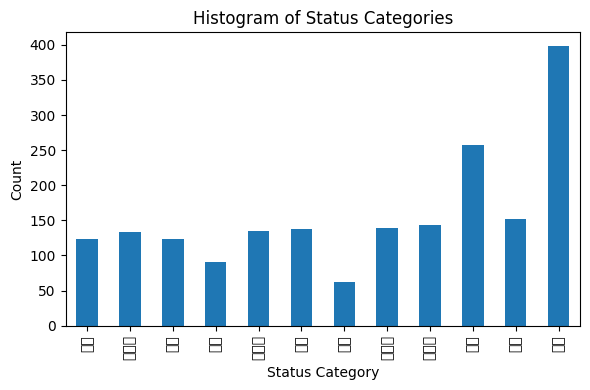

In [4]:
import matplotlib.pyplot as plt
df['status'] = df.status_text.str.extract("([가-힣]+)~")
df['status'] = df['status'].astype('category') # 카테고리로 전환
print("\n카테고리 목록:", df["status"].cat.categories.tolist())
print("카테고리 개수 :", df["status"].nunique())
print('결측치(nan)의 갯수 :', df['status'].isna().sum())
print('train 결측치(nan)의 갯수 :', df[:size]['status'].isna().sum())
print('test 결측치(nan)의 갯수 :', df[size:]['status'].isna().sum())

counts = df["status"].value_counts().sort_index()
plt.figure(figsize=(6, 4))
counts.plot(kind="bar")
plt.xlabel("Status Category")
plt.ylabel("Count")
plt.title("Histogram of Status Categories")
plt.tight_layout()
plt.show()

In [5]:
df.smartphone_usage

0        커뮤니티 16시간, 유튜브 15시간, SNS 8시간
1       커뮤니티 16시간, 유튜브 33시간, SNS 25시간
2       커뮤니티 29시간, 유튜브 10시간, SNS 26시간
3        커뮤니티 13시간, 유튜브 7시간, SNS 19시간
4        커뮤니티 21시간, 유튜브 8시간, SNS 30시간
                    ...              
1995     커뮤니티 20시간, 유튜브 13시간, SNS 1시간
1996     커뮤니티 2시간, 유튜브 22시간, SNS 13시간
1997     커뮤니티 5시간, 유튜브 12시간, SNS 19시간
1998       커뮤니티 9시간, 유튜브 7시간, SNS 7시간
1999    커뮤니티 14시간, 유튜브 11시간, SNS 15시간
Name: smartphone_usage, Length: 2000, dtype: object

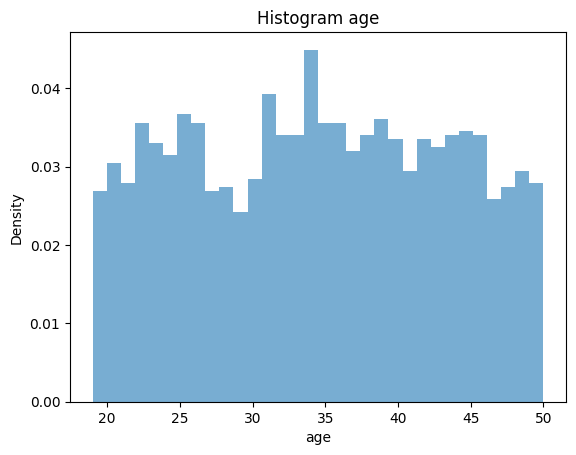

In [6]:
import matplotlib.pyplot as plt
age = df['age']
fig1, ax1 = plt.subplots()
#ax1.hist(data_norm, bins='auto', density=True, alpha=0.6)        # 히스토그램 (밀도 스케일)
ax1.hist(age, bins=(50-19+1), density=True, alpha=0.6)        # 히스토그램 (밀도 스케일)
ax1.set_xlabel("age")
ax1.set_ylabel("Density")
ax1.set_title("Histogram age")
plt.show()

In [7]:
# 추가 작업을 위한 셀
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

df.gender = df.gender.fillna("F")

#df.status_text = df.status_text.str.extract("([가-힣]+)~")
df['status'] = df.status_text.str.extract("([가-힣]+)~")
df['status'] = df['status'].astype('category')

df.smartphone_usage = df.smartphone_usage.astype(str)
#df.smartphone_usage = df.smartphone_usage.str.extract("커뮤니티 ([0-9]+)시간").astype(int)+df.smartphone_usage.str.extract("유튜브 ([0-9]+)시간").astype(int)+df.smartphone_usage.str.extract("SNS ([0-9]+)시간").astype(int)
df['community'] = df.smartphone_usage.str.extract("커뮤니티 ([0-9]+)시간").astype(int)
df['youtube'] = df.smartphone_usage.str.extract("유튜브 ([0-9]+)시간").astype(int)
df['sns'] = df.smartphone_usage.str.extract("SNS ([0-9]+)시간").astype(int)

df["nage"] = df['age'] # age는 연속 값이므로, class화 할 필요가 없다.
df["ngender"] = df.gender.replace(["M" , "F"], [0,1])
#df["nsmartphone_usage"] = df['smartphone_usage']
# sleeping_hour는 가능한 한 유사한 float 값으로 변환
df["nsleeping_hour"] = df.sleeping_hour.map({"4시간 미만":3.5, "4시간~5시간":4.5, "5시간~6시간":5.5, "6시간~7시간":6.5, "7시간~8시간":7.5, "8시간~9시간":8.5, "9시간 초과":9.5 })
#df["nstatus_text"] = df.status_text.map({"기쁨":0 , "즐거움":0 , "설렘":0 , "웃음":0, "평소":1,
#                                        "평온":1, "평범":1, "일상적":1, "무기력":2, "쓸쓸함":2, "불안":2, "우울":2})

# 결측값 채우기
df_known   = df[df["status"].notna()].copy()
df_missing = df[df["status"].isna()].copy()

X_known   = df_known.drop(columns=["status"])
y_known   = df_known["status"]
X_missing = df_missing.drop(columns=["status"])


# 전처리 + 모델 파이프라인 
num_cols  = X_known.select_dtypes(include=["number"]).columns
cat_cols  = X_known.select_dtypes(exclude=["number"]).columns

num_cols = num_cols.drop(['id', 'satisfaction'])
cat_cols = cat_cols.drop(['gender', 'smartphone_usage', 'sleeping_hour', 'status_text'])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

#{'model__bootstrap': True, 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__n_estimators': 1600}

rf = RandomForestClassifier(
    bootstrap=True,
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    n_estimators=1600,
    random_state=42,
    class_weight="balanced"   # 라벨 불균형 완화
)

clf = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", rf)
])

#clf.fit(X_known, y_known)

# 결측행 예측 & 채우기 
#preds = clf.predict(X_missing)
#df.loc[df["status"].isna(), "status"] = preds

df



,id,age,gender,smartphone_usage,sleeping_hour,status_text,satisfaction,status,community,youtube,sns,nage,ngender,nsleeping_hour
0,1,49,F,"커뮤니티 16시간, 유튜브 15시간, SNS 8시간",5시간~6시간,무기력~한 이 상태에서 벗어나고 싶다,0.0,무기력,16,15,8,49,1,5.5
1,2,46,F,"커뮤니티 16시간, 유튜브 33시간, SNS 25시간",4시간~5시간,오늘은 유난히 평소~의 기분이 좋았다,0.0,평소,16,33,25,46,1,4.5
2,3,47,M,"커뮤니티 29시간, 유튜브 10시간, SNS 26시간",4시간~5시간,불안~한 꿈속으로 내가 빠져버린 것 같다,0.0,불안,29,10,26,47,0,4.5
3,4,32,M,"커뮤니티 13시간, 유튜브 7시간, SNS 19시간",5시간~6시간,나무 그늘에서 평온~하게 독서를 하였다,0.0,평온,13,7,19,32,0,5.5
4,5,23,F,"커뮤니티 21시간, 유튜브 8시간, SNS 30시간",4시간~5시간,오늘 결국엔 아무 일 없이 평온~했다,0.0,평온,21,8,30,23,1,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1996,22,F,"커뮤니티 20시간, 유튜브 13시간, SNS 1시간",5시간~6시간,소중한 사람과의 즐거움~이 필요해,NaN,즐거움,20,13,1,22,1,5.5
1996,1997,37,F,"커뮤니티 2시간, 유튜브 22시간, SNS 13시간",6시간~7시간,무기력~함에 사로잡혀 시간만 흘러간다,NaN,무기력,2,22,13,37,1,6.5
1997,1998,24,M,"커뮤니티 5시간, 유튜브 12시간, SNS 19시간",9시간 초과,이런 평온~한 날들이 계속되길 바란다,NaN,평온,5,12,19,24,0,9.5
1998,1999,43,M,"커뮤니티 9시간, 유튜브 7시간, SNS 7시간",9시간 초과,평온~한 상태를 유지하고 싶다,NaN,평온,9,7,7,43,0,9.5


# **EDA**
+ 예) 클래스 개수 파악

+ 예) 나이와 만족도 간의 관계

# **Machine Learning**

In [8]:
#to_remove = ['id', 'age', 'gender', 'smartphone_usage',
#             'sleeping_hour', 'status_text', 'satisfaction']

#X_train = df[:size].drop(columns=to_remove)
y_train = df[:size].satisfaction
#X_test = df[size:].drop(columns=to_remove)
y_test = df[size:].satisfaction

# 학습 데이터값 확인
#X_train.head()

In [9]:
print("\n카테고리 목록:", df["status"].cat.categories.tolist())



카테고리 목록: ['기쁨', '무기력', '불안', '설렘', '쓸쓸함', '우울', '웃음', '일상적', '즐거움', '평범', '평소', '평온']


In [10]:
df["nstatus_text"] = df.status.map({"기쁨":0 , "즐거움":0 , "설렘":0 , "웃음":0, "평소":1,
                                        "평온":1, "평범":1, "일상적":1, "무기력":2, "쓸쓸함":2, "불안":2, "우울":2})

In [11]:
df

,id,age,gender,smartphone_usage,sleeping_hour,status_text,satisfaction,status,community,youtube,sns,nage,ngender,nsleeping_hour,nstatus_text
0,1,49,F,"커뮤니티 16시간, 유튜브 15시간, SNS 8시간",5시간~6시간,무기력~한 이 상태에서 벗어나고 싶다,0.0,무기력,16,15,8,49,1,5.5,2.0
1,2,46,F,"커뮤니티 16시간, 유튜브 33시간, SNS 25시간",4시간~5시간,오늘은 유난히 평소~의 기분이 좋았다,0.0,평소,16,33,25,46,1,4.5,1.0
2,3,47,M,"커뮤니티 29시간, 유튜브 10시간, SNS 26시간",4시간~5시간,불안~한 꿈속으로 내가 빠져버린 것 같다,0.0,불안,29,10,26,47,0,4.5,2.0
3,4,32,M,"커뮤니티 13시간, 유튜브 7시간, SNS 19시간",5시간~6시간,나무 그늘에서 평온~하게 독서를 하였다,0.0,평온,13,7,19,32,0,5.5,1.0
4,5,23,F,"커뮤니티 21시간, 유튜브 8시간, SNS 30시간",4시간~5시간,오늘 결국엔 아무 일 없이 평온~했다,0.0,평온,21,8,30,23,1,4.5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1996,22,F,"커뮤니티 20시간, 유튜브 13시간, SNS 1시간",5시간~6시간,소중한 사람과의 즐거움~이 필요해,NaN,즐거움,20,13,1,22,1,5.5,0.0
1996,1997,37,F,"커뮤니티 2시간, 유튜브 22시간, SNS 13시간",6시간~7시간,무기력~함에 사로잡혀 시간만 흘러간다,NaN,무기력,2,22,13,37,1,6.5,2.0
1997,1998,24,M,"커뮤니티 5시간, 유튜브 12시간, SNS 19시간",9시간 초과,이런 평온~한 날들이 계속되길 바란다,NaN,평온,5,12,19,24,0,9.5,1.0
1998,1999,43,M,"커뮤니티 9시간, 유튜브 7시간, SNS 7시간",9시간 초과,평온~한 상태를 유지하고 싶다,NaN,평온,9,7,7,43,0,9.5,1.0


In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown="ignore",
                          sparse_output=False)),
    ("lda", LinearDiscriminantAnalysis(n_components=2))
])


# 감정(문자열)만 X, 타깃 y
#X_low = pipe.fit_transform(df[:size][["status"]], df[:size]["satisfaction"])
df_train = df[:size]
df_train_status = df_train[df_train['status'].notna()] # nan이 아닌 status만 모음
df_status = df[df['status'].isna()==False]
#result = pipe.fit(df[:size][["status"]], df[:size]["satisfaction"])
result = pipe.fit(df_train_status[["status"]], df_train_status["satisfaction"])
#X_low = result.transform(df[["status"]])
X_low = result.transform(df_status[["status"]])
# 결과 : shape (n_samples, 2)  -> 1개만 원하면 n_components=1
size_status = len(df_train_status)
print('no of train without nan =', size_status)

no of train without nan = 950


In [13]:
df_status[["status"]]

,status
0,무기력
1,평소
2,불안
3,평온
4,평온
...,...
1995,즐거움
1996,무기력
1997,평온
1998,평온


pearson = 0.7434153633505532


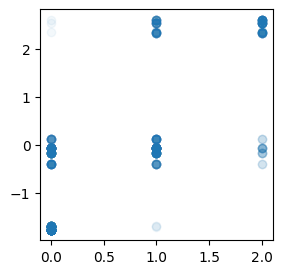

In [14]:
from scipy.stats import pearsonr
X1 = X_low[:size_status, 0]
feature = X1
labels=df_status[:size_status]["satisfaction"]
pearson, _ = pearsonr(feature, labels)
print('pearson =', pearson)

import matplotlib.pyplot as plt

plt.figure(figsize=(3,3))
plt.scatter(labels, feature, alpha=0.05)
plt.show()

pearson = 0.014798476092365839


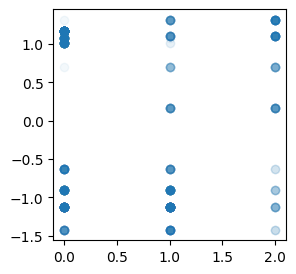

In [15]:
X2 = X_low[:size_status, 1]
feature = X2
labels=df_status[:size_status]["satisfaction"]
pearson, _ = pearsonr(feature, labels)
print('pearson =', pearson)

import matplotlib.pyplot as plt

plt.figure(figsize=(3,3))
plt.scatter(labels, feature, alpha=0.05)
plt.show()

In [16]:
import numpy as np
df['nstatus_text'] = np.nan
#df[df['status'].notna()]['nstatus_text'] = X_low[:, 0] 
df['nstatus_text'][df['status'].notna()] = X_low[:, 0] 

In [17]:
print('total nan status number =', df['nstatus_text'].isna().sum())

total nan status number = 104


In [18]:
df['nsmartphone_usage'] = df['community']+df['youtube']+df['sns']

In [19]:
to_remove = ['id', 'age', 'gender', 'smartphone_usage',
             'sleeping_hour', 'status_text', 'satisfaction', 'status',
             'community', 'youtube', 'sns', 'ngender',
            ]

#X_status = pd.get_dummies(df["status"], prefix="status")   # 'color_blue', … 열 생성
X_other = df[df.columns.drop(to_remove)]                                   # 연속형 피처 예시
#X       = pd.concat([X_status, X_other], axis=1)
X       = X_other
X_train = X[:size]
X_test = X[size:]
X_train.head()

,nage,nsleeping_hour,nstatus_text,nsmartphone_usage
0,49,5.5,-1.682244,39
1,46,4.5,0.132302,74
2,47,4.5,-1.763513,65
3,32,5.5,-0.063734,39
4,23,4.5,-0.063734,59


In [20]:
# 학습 데이터의 클래스값 확인
y_train.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: satisfaction, dtype: float64

# 상관계수 분석

pearson = -0.7657333043939127


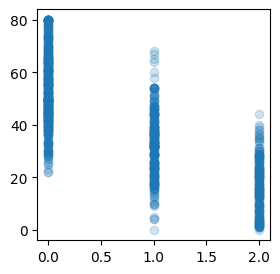

In [21]:
from scipy.stats import pearsonr
labels = y_train
feature = X_train['nsmartphone_usage']

pearson, _ = pearsonr(feature, labels)
print('pearson =', pearson)

import matplotlib.pyplot as plt

plt.figure(figsize=(3,3))
plt.scatter(labels, feature, alpha=0.2)
plt.show()

pearson = 0.7434153633505532


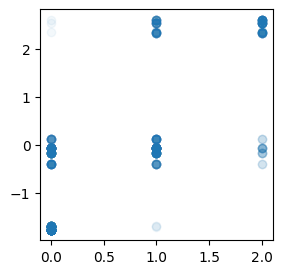

In [22]:
from scipy.stats import pearsonr
labels = y_train[X_train['nstatus_text'].notna()]
feature = X_train['nstatus_text'][X_train['nstatus_text'].notna()]

pearson, _ = pearsonr(feature, labels)
print('pearson =', pearson)

import matplotlib.pyplot as plt

plt.figure(figsize=(3,3))
plt.scatter(labels, feature, alpha=0.05)
plt.show()

+ 여러가지 머신러닝 모델로 학습 데이터셋에 대해 교차검증을 수행하며 성능이 좋은 것을 찾는다

In [23]:
X_train_status = X_train[X_train['nstatus_text'].notna()]
y_train_status = y_train[X_train['nstatus_text'].notna()]

In [24]:
from random import Random
from xgboost import XGBClassifier
from sklearn.preprocessing   import StandardScaler
from sklearn.neural_network  import MLPClassifier
from sklearn.pipeline        import Pipeline
from sklearn.pipeline import make_pipeline

# 필요한 머신러닝 함수 혹은 하이퍼패러미터를 추가하거나 불필요한 함수를 삭제하는 등 자유롭게 수정하세요
dt = DecisionTreeClassifier(criterion='gini', max_depth=6, max_features=None,
                                                     min_samples_leaf=2, min_samples_split=2, random_state=1)
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                                             learning_rate=0.1,
                                             n_estimators=200, random_state=1)
rf = RandomForestClassifier(bootstrap=False, max_depth=10, max_features=0.6, 
                          min_samples_leaf=2,
                          n_estimators=800, random_state=1)

mlp = make_pipeline( StandardScaler(),
                     MLPClassifier(hidden_layer_sizes=(16, 8),
                                      activation="relu",
                                      max_iter=2000,
                                      random_state=42,
                                      solver="adam",
                                      alpha=1e-8,
                                      learning_rate_init=0.0005,
                                      batch_size=4,
                     )
       )
                    
xgb =  XGBClassifier(
                    objective    = "binary:logistic",
                    eval_metric  = "logloss",
                    tree_method  = "hist",
                    random_state = 1,
                    n_jobs       = -1,
                    colsample_bytree =  0.8,
                    gamma =  1,
                    learning_rate= 0.01,
                    max_depth = 7, 
                    n_estimators = 800, 
                    subsample =  1.0 )

estimator1 = [("dt",dt),("rf",rf),("ada",ada),("mlp", mlp),("xgb", xgb)]
vt=VotingClassifier(estimators=estimator1, voting="hard")
#estimator2 = [("rf",rf),("vt",vt)]
estimator2 = [("dt",dt),("rf",rf),("ada",ada),("mlp", mlp),("xgb", xgb)]

classifiers = {"DecisionTree":DecisionTreeClassifier(criterion='gini', max_depth=6, max_features=None,
                                                     min_samples_leaf=2, min_samples_split=2, random_state=1),
               "AdaBoost":AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                                             learning_rate=0.1,
                                             n_estimators=200, random_state=1),
               "RandomForest": RandomForestClassifier(bootstrap=False, max_depth=10, max_features=0.6, 
                                                      min_samples_leaf=2,
                                                      n_estimators=800, random_state=1),
               "XGBoost": XGBClassifier(
                    objective    = "binary:logistic",
                    eval_metric  = "logloss",
                    tree_method  = "hist",
                    random_state = 1,
                    n_jobs       = -1,
                    colsample_bytree =  0.8,
                    gamma =  1,
                    learning_rate= 0.01,
                    max_depth = 7, 
                    n_estimators = 800, 
                    subsample =  1.0,
                ),
               "MLP": make_pipeline(
                    StandardScaler(),
                    MLPClassifier(hidden_layer_sizes=(16, 8),
                                  activation="relu",
                                  max_iter=2000,
                                  random_state=42,
                                  solver="adam",
                                  alpha=1e-8,
                                  learning_rate_init=0.0005,
                                  batch_size=4,
                                 )
                ),
               "Voting": VotingClassifier(estimators=estimator1, voting="hard"),
               "Stacking":StackingClassifier(estimators=estimator2)
               }

# clfs에 나열된 항목에 대해 차례로 교차검증 수행
for name, clf in classifiers.items():
    print(name, cross_val_score(clf, X_train_status, y_train_status).mean().round(4))

DecisionTree 0.94
AdaBoost 0.9453
RandomForest 0.9379
XGBoost 0.94
MLP 0.9442
Voting 0.9453
Stacking 0.9379


# 결측치 학습

In [25]:
X_train_nostatus = X_train.drop(columns=['nstatus_text'])

In [26]:
# 필요한 머신러닝 함수 혹은 하이퍼패러미터를 추가하거나 불필요한 함수를 삭제하는 등 자유롭게 수정하세요
dt = DecisionTreeClassifier(criterion='gini', max_depth=6, max_features=None,
                                                     min_samples_leaf=2, min_samples_split=2, random_state=1)
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                                             learning_rate=0.1,
                                             n_estimators=200, random_state=1)
rf = RandomForestClassifier(bootstrap=False, max_depth=10, max_features=0.6, 
                          min_samples_leaf=2,
                          n_estimators=800, random_state=1)

mlp = make_pipeline( StandardScaler(),
                     MLPClassifier(hidden_layer_sizes=(16, 8),
                                      activation="relu",
                                      max_iter=2000,
                                      random_state=42,
                                      solver="adam",
                                      alpha=1e-8,
                                      learning_rate_init=0.0005,
                                      batch_size=4,
                     )
       )
                    
xgb =  XGBClassifier(
                    objective    = "binary:logistic",
                    eval_metric  = "logloss",
                    tree_method  = "hist",
                    random_state = 1,
                    n_jobs       = -1,
                    colsample_bytree =  0.8,
                    gamma =  1,
                    learning_rate= 0.01,
                    max_depth = 7, 
                    n_estimators = 800, 
                    subsample =  1.0 )

estimator1 = [("dt",dt),("rf",rf),("ada",ada),("mlp", mlp),("xgb", xgb)]
vt=VotingClassifier(estimators=estimator1, voting="hard")
#estimator2 = [("rf",rf),("vt",vt)]
estimator2 = [("dt",dt),("rf",rf),("ada",ada),("mlp", mlp),("xgb", xgb)]

classifiers = {"DecisionTree":DecisionTreeClassifier(criterion='gini', max_depth=6, max_features=None,
                                                     min_samples_leaf=2, min_samples_split=2, random_state=1),
               "AdaBoost":AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                                             learning_rate=0.1,
                                             n_estimators=200, random_state=1),
               "RandomForest": RandomForestClassifier(bootstrap=False, max_depth=10, max_features=0.6, 
                                                      min_samples_leaf=2,
                                                      n_estimators=800, random_state=1),
               "XGBoost": XGBClassifier(
                    objective    = "binary:logistic",
                    eval_metric  = "logloss",
                    tree_method  = "hist",
                    random_state = 1,
                    n_jobs       = -1,
                    colsample_bytree =  0.8,
                    gamma =  1,
                    learning_rate= 0.01,
                    max_depth = 7, 
                    n_estimators = 800, 
                    subsample =  1.0,
                ),
               "MLP": make_pipeline(
                    StandardScaler(),
                    MLPClassifier(hidden_layer_sizes=(16, 8),
                                  activation="relu",
                                  max_iter=2000,
                                  random_state=42,
                                  solver="adam",
                                  alpha=1e-8,
                                  learning_rate_init=0.0005,
                                  batch_size=4,
                                 )
                ),
               "Voting": VotingClassifier(estimators=estimator1, voting="hard"),
               "Stacking":StackingClassifier(estimators=estimator2)
               }

# clfs에 나열된 항목에 대해 차례로 교차검증 수행
for name, clf in classifiers.items():
    print(name, cross_val_score(clf, X_train_nostatus, y_train).mean().round(4))

DecisionTree 0.745
AdaBoost 0.771
RandomForest 0.752
XGBoost 0.763
MLP 0.767
Voting 0.774
Stacking 0.765


# 특징(feature) 중요도 분석

In [27]:
from sklearn.inspection import permutation_importance
rf = RandomForestClassifier(bootstrap=False, max_depth=10, max_features=0.6, 
                          min_samples_leaf=2,
                          n_estimators=800, random_state=1)
rf.fit(X_train_status, y_train_status)
dt = DecisionTreeClassifier(criterion='gini', max_depth=6, max_features=None,
                                                     min_samples_leaf=2, min_samples_split=2, random_state=1)
dt.fit(X_train_status, y_train_status)


feature_names = X_train_status.columns
imp_rf = pd.Series(rf.feature_importances_, index=feature_names)
imp_dt = pd.Series(dt.feature_importances_, index=feature_names)
perm_rf = permutation_importance(rf, X_train_status, y_train_status, n_repeats=15,
                                 scoring="accuracy", random_state=0, n_jobs=-1)
perm_dt = permutation_importance(dt, X_train_status, y_train_status, n_repeats=15,
                                 scoring="accuracy", random_state=0, n_jobs=-1)
perm_rf_imp = pd.Series(perm_rf.importances_mean, index=feature_names)
perm_dt_imp = pd.Series(perm_dt.importances_mean, index=feature_names)


Random Forest – Gini 중요도 TOP10
nstatus_text         0.368515
nsmartphone_usage    0.366170
nsleeping_hour       0.228250
nage                 0.037065
dtype: float64

Random Forest – Permutation 중요도 TOP10
nstatus_text         0.317895
nsmartphone_usage    0.304842
nsleeping_hour       0.181123
nage                 0.030246
dtype: float64


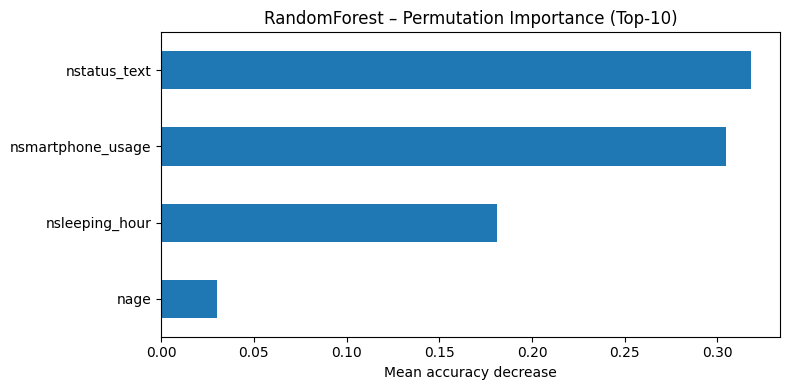

In [28]:
print("\nRandom Forest – Gini 중요도 TOP10")
print(imp_rf.sort_values(ascending=False).head(10))
print("\nRandom Forest – Permutation 중요도 TOP10")
print(perm_rf_imp.sort_values(ascending=False).head(10))
# 7. 시각화 (Random Forest Permutation 기준 상위 10개 막대 그래프)
top10 = perm_rf_imp.sort_values(ascending=False).head(10)
plt.figure(figsize=(8, 4))
top10[::-1].plot(kind="barh")          # 역순으로 그려 가로 막대
plt.title("RandomForest – Permutation Importance (Top-10)")
plt.xlabel("Mean accuracy decrease")
plt.tight_layout()
plt.show()


Decision Tree – Gini 중요도 TOP10
nsmartphone_usage    0.476208
nstatus_text         0.405320
nsleeping_hour       0.111071
nage                 0.007401
dtype: float64

Decision Tree – Permutation 중요도 TOP10
nstatus_text         0.283298
nsmartphone_usage    0.283158
nsleeping_hour       0.150526
nage                 0.004281
dtype: float64


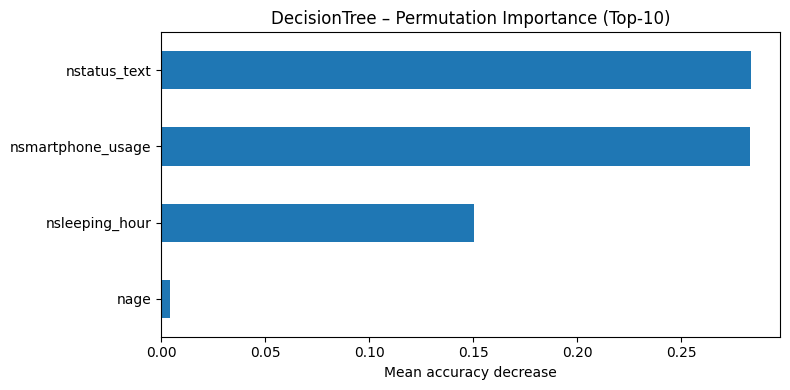

In [29]:
print("\nDecision Tree – Gini 중요도 TOP10")
print(imp_dt.sort_values(ascending=False).head(10))
print("\nDecision Tree – Permutation 중요도 TOP10")
print(perm_dt_imp.sort_values(ascending=False).head(10))
# 7. 시각화 (Random Forest Permutation 기준 상위 10개 막대 그래프)
top10 = perm_dt_imp.sort_values(ascending=False).head(10)
plt.figure(figsize=(8, 4))
top10[::-1].plot(kind="barh")          # 역순으로 그려 가로 막대
plt.title("DecisionTree – Permutation Importance (Top-10)")
plt.xlabel("Mean accuracy decrease")
plt.tight_layout()
plt.show()

# 최적화 parameter 탐색 (여기는 실행하지 말고 skip )

In [30]:
'''
# ------------------------------------------------------------------
param_grid = {
    "n_estimators":    [800, 1600],
    "max_depth":       [None, 10, 20, 30],
    "min_samples_leaf":[1, 2, 4],
    "max_features":    ["sqrt", 0.6, 1.0],   # 분류 기본 'sqrt'
    "bootstrap":       [True, False]
}

rf      = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_cv = GridSearchCV(
    estimator  = rf,
    param_grid = param_grid,
    cv         = 5,
    scoring    = "accuracy",
    n_jobs     = -1,
    verbose    = 1
)
grid_cv.fit(X_train, y_train)

print("🔎 GridSearch 최고 파라미터")
print(grid_cv.best_params_)
print(f"CV AUC = {grid_cv.best_score_:.4f}")

'''
None

In [31]:
'''
param_grid = {
    #"model__n_estimators":    [200, 400, 800],
    "model__n_estimators":    [1600, 2000],
    #"model__max_depth":       [None, 10, 20, 30],
    "model__max_depth":       [None, 30],
    #"model__min_samples_leaf":[1, 2, 4],
    "model__min_samples_leaf":[1, 2],
    #"model__max_features":    ["sqrt", 0.6, 1.0],   # 분류 기본 'sqrt'
    "model__max_features":    ["sqrt"],   # 분류 기본 'sqrt'
    "model__bootstrap":       [True, False]
}
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced"   # 라벨 불균형 완화
)

clf = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", rf)
])

grid_cv = GridSearchCV(
    estimator  = clf,
    param_grid = param_grid,
    cv         = 5,
    scoring    = "accuracy",
    n_jobs     = -1,
    verbose    = 1
)
grid_cv.fit(X_known, y_known)
print("🔎 GridSearch 최고 파라미터")
print(grid_cv.best_params_)
print(f"CV AUC = {grid_cv.best_score_:.4f}")
'''
None

In [32]:
'''
# ------------------------------------------------------------------
# 1) 그리드 정의
# ------------------------------------------------------------------
param_grid = {
    "criterion":         ["gini", "entropy", "log_loss"],
    "max_depth":         [None, 4, 6, 8, 12],
    "min_samples_split": [2, 4, 8, 16],
    "min_samples_leaf":  [1, 2, 4],
    "max_features":      [None, "sqrt", "log2"]
}

# ------------------------------------------------------------------
# 2) GridSearchCV 설정 & 학습
# ------------------------------------------------------------------
dt     = DecisionTreeClassifier(random_state=42)
grid   = GridSearchCV(
    estimator   = dt,
    param_grid  = param_grid,
    cv          = 5,               # 5-fold 교차검증
    scoring     = "accuracy",      # 필요 시 'roc_auc_ovo', 'f1_macro' 등 교체
    n_jobs      = -1,
    verbose     = 1
)
grid.fit(X_train, y_train)

# ------------------------------------------------------------------
# 3) 결과 확인
# ------------------------------------------------------------------
print("\n📌 최적 하이퍼파라미터")
for k, v in grid.best_params_.items():
    print(f"  {k:18s}: {v}")

print(f"\nCV 최고 정확도  : {grid.best_score_:.4f}")
'''
None

In [33]:
'''
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# 2) 기본 약한 학습기(결정트리) 설정 -------------------------------
weak_tree = DecisionTreeClassifier(
    max_depth=1,                # 스텀프
    random_state=42
)

# 3-A) Grid Search -----------------------------------------------
param_grid = {
    "n_estimators": [50, 100, 200, 400],
    "learning_rate": [0.05, 0.1, 0.2, 0.5, 1.0],
    "estimator__max_depth": [1, 2, 3]   # base_estimator → estimator
}

ada = AdaBoostClassifier(
    estimator=weak_tree,      # ← 여기!
    n_estimators=400,
    learning_rate=0.1,
    random_state=42
)
grid = GridSearchCV(
    ada,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("\n📌 GridSearch 최고 파라미터:")
print(grid.best_params_)
print(f"CV 정확도: {grid.best_score_:.4f}")
'''
None

In [34]:
'''
from sklearn.svm             import SVC
from sklearn.datasets        import load_wine          # 다중 클래스 예시
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,
                                     StratifiedKFold)
from sklearn.metrics         import (classification_report,
                                     accuracy_score)

# 1) 데이터 준비 ──────────────────────────────────────────────

# 2) SVC 기본 설정 ───────────────────────────────────────────
#    - probability=True : predict_proba 사용(원한다면 False로)
svc_base = SVC(probability=True, random_state=42)

# 3) 하이퍼파라미터 그리드 ───────────────────────────────────
param_grid = [
    # (1) RBF 커널
    {
        "kernel": ["rbf"],
        "C":      [0.1, 1, 10, 100],
        "gamma":  ["scale", 0.01, 0.1, 1]
    },
    # (2) 선형 커널
    {
        "kernel": ["linear"],
        "C":      [0.1, 1, 10, 100]
    },
    # (3) 다항 커널
    {
        "kernel": ["poly"],
        "C":      [0.1, 1, 10],
        "gamma":  ["scale", 0.1],
        "degree": [2, 3, 4],
        "coef0":  [0]                # bias term
    }
]

# 4) GridSearchCV ────────────────────────────────────────────
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator   = svc_base,
    param_grid  = param_grid,
    scoring     = "accuracy",          # 원하는 지표로 교체 가능
    cv          = cv,
    n_jobs      = -1,
    verbose     = 1
)
grid.fit(X_train, y_train)

print("\n🔎 최적 하이퍼파라미터")
for k, v in grid.best_params_.items():
    print(f"  {k:<8}: {v}")
print(f"CV 최고 정확도 : {grid.best_score_:.4f}")
'''
None

In [35]:
'''
import numpy as np
from xgboost import XGBClassifier
from sklearn.datasets import load_breast_cancer      # 이진 분류 예시
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report

# ──────────────────────────────────────────────────────────────
# 1. 데이터 준비
# ──────────────────────────────────────────────────────────────

# ──────────────────────────────────────────────────────────────
# 2. 그리드 정의
#    - 범위를 좁혀서 촘촘히 찾고 싶을 땐 값 개수를 줄이거나
#      RandomizedSearchCV와 병행해도 좋습니다.
# ──────────────────────────────────────────────────────────────
# 2) 기본 모델
base_xgb = XGBClassifier(
    objective    = "binary:logistic",
    eval_metric  = "logloss",
    tree_method  = "hist",
    random_state = 42,
    n_jobs       = -1
)

# 3) 하이퍼파라미터 그리드
param_grid = {
    "n_estimators":      [200, 400, 800],
    "learning_rate":     [0.01, 0.05, 0.1],
    "max_depth":         [3, 5, 7],
    "subsample":         [0.8, 1.0],
    "colsample_bytree":  [0.8, 1.0],
    "gamma":             [0, 1, 5]
}

# 4) GridSearchCV (accuracy 기준)
grid = GridSearchCV(
    estimator   = base_xgb,
    param_grid  = param_grid,
    scoring     = "accuracy",        # ★ 변경
    cv          = 5,
    n_jobs      = -1,
    verbose     = 1
)
grid.fit(X_train, y_train)

print("\n🔎 최적 파라미터:", grid.best_params_)
print(f"CV 최고 정확도  : {grid.best_score_:.4f}")
'''
None

In [36]:
'''
from sklearn.preprocessing   import StandardScaler
from sklearn.neural_network  import MLPClassifier
from sklearn.pipeline        import Pipeline
# ─────────────────────────────────────────────────────────────
# 1) 파이프라인 (표준화 → MLP)
# ─────────────────────────────────────────────────────────────
pipe = Pipeline([
    ("scale", StandardScaler()),
    ("mlp",   MLPClassifier(
        activation="relu",
        max_iter=2000,
        solver="adam",
        random_state=42,
        #early_stopping=True,
        validation_fraction=0.2,
        #n_iter_no_change=10,
    ))
])

# ─────────────────────────────────────────────────────────────
# 2) 하이퍼파라미터 그리드
#    - hidden_layer_sizes: 층 개수·노드 수 조합
#    - alpha             : L2 정규화
#    - learning_rate_init: 초기 학습률
# ─────────────────────────────────────────────────────────────
param_grid = {
    #"mlp__hidden_layer_sizes": [(32,), (32,16)],
    "mlp__hidden_layer_sizes": [(32,8),(16,8)],
    #"mlp__alpha":              [1e-5, 1e-4, 1e-3],
    "mlp__alpha":              [1e-8],
    #"mlp__learning_rate_init": [0.001, 0.01],
    "mlp__learning_rate_init": [0.0005],
    "mlp__batch_size":         [2, 4]
}

# ─────────────────────────────────────────────────────────────
# 3) GridSearchCV
#    - 5-fold Stratified CV, 정확도 기준
# ─────────────────────────────────────────────────────────────
grid = GridSearchCV(
    estimator = pipe,
    param_grid= param_grid,
    scoring   = "accuracy",
    cv        = 5,
    n_jobs    = -1,
    verbose   = 1
)
grid.fit(X_train, y_train)

print("\n🔎 최적 하이퍼파라미터")
for k, v in grid.best_params_.items():
    print(f"  {k:25s}: {v}")
print(f"CV 최고 정확도   : {grid.best_score_:.4f}")
'''
None

+ 가장 결과가 잘 나오는 모델을 피팅하여 result 변수에 넣고 테스트 데이터를 입력하여 예측 결과를 y_pred에 생성한다

# 추론

In [37]:
# nan 갯수
X_test.nstatus_text.isna().sum()

np.int64(54)

In [38]:
# 다음은 예시 모델입니다. 자신의 분류모델과 패러미터로 수정하세요
# status 있는 데이터에 대해서만 학습
result_status = VotingClassifier(estimators=estimator1, voting='hard').fit(X_train_status, y_train_status)
#result =  StackingClassifier(estimators=estimator2).fit(X_train, y_train) 

X_test_status = X_test[X_test['nstatus_text'].notna()]
y_pred_status = result_status.predict(X_test_status).astype(int) # 완성된 코드

print(y_pred_status[:10]) # 지면상 첫 10개만 출력

[1 1 1 0 0 1 1 0 1 1]


In [39]:
# status를 feature에서 빼고 전체 train data에 대해 학습
X_test_nostatus = X_test.drop(columns='nstatus_text')
result_nostatus = VotingClassifier(estimators=estimator1, voting='hard').fit(X_train_nostatus, y_train)
y_pred_nostatus = result_nostatus.predict(X_test_nostatus[X_test['nstatus_text'].isna()]).astype(int) # 완성된 코드

print('status 있는 갯수 =', len(y_pred_status), '없는 갯수 =', len(y_pred_nostatus))

status 있는 갯수 = 946 없는 갯수 = 54


In [40]:
y_pred = y_test.copy()
y_pred[X_test['nstatus_text'].notna()] = y_pred_status
y_pred[X_test['nstatus_text'].isna()] = y_pred_nostatus
y_pred = list(y_pred.astype('int'))
y_pred[:10]

[1, 1, 1, 0, 0, 1, 1, 1, 0, 2]

In [41]:
# trainset 인식률 점검
y_train_pred_status = result_status.predict(X_train_status).astype('int')
y_train_pred_nostatus = result_nostatus.predict(X_train_nostatus[X_train['nstatus_text'].isna()]).astype('int')

y_train_pred = y_train.copy()
y_train_pred[X_train['nstatus_text'].notna()] = y_train_pred_status
y_train_pred[X_train['nstatus_text'].isna()] = y_train_pred_nostatus
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_train, y_train_pred)
acc

0.954

In [42]:
0.95*0.9453 + 0.05*0.774

0.936735

In [43]:
print(len(y_train_pred_status)+len(y_train_pred_nostatus))
(y_train_pred == 2).sum()

1000


np.int64(192)

In [44]:
0.868, 0.894

(0.868, 0.894)

# **Submission**
+ 1) 아래 셀을 실행하여 생성된 파일을 다운로드 하여 캐글에 제출
  + 코드에서 filename을 학번으로 변경
  + 캐글의 Team Name을 학번의 마지막 4자리로 변경(미변경시 미제출처리)
+ 2) 본 노트북 파일을 과제 사이트의 15주차에 제출(기한 이후 제출시 감점)
+ 3) 아래 출력되는 링크에서 반드시 제출 기한, 채점 기준 등을 확인

In [45]:
submit_form = pd.read_csv("submit_form.csv") # 답안 양식을 불러온다.
submit_form["satisfaction"] = y_pred # 이전 셀에서 생성한 답안을 입력

# X부분의 학번을 정확히 작성 (추가 정보는 _로 붙일 수 있습니다)
# 예) "2025112345_SVC_ver1.0"
filename = "2025122028_status_v6"

# 캐글에 제출할 파일 생성(왼쪽 드라이브 폴더에서 다운로드 하여 제출)
submit_form.to_csv(f"{filename}.csv", index=False)

# 출력된 링크를 클릭하여 제출 방법 등 확인
print('과제 제출을 위해 kaggle.com에 가입합니다(필수)')
print("https://www.kaggle.com/t/7789925876b74fd3a0d87bc828711c86")

과제 제출을 위해 kaggle.com에 가입합니다(필수)
https://www.kaggle.com/t/7789925876b74fd3a0d87bc828711c86


In [46]:
'''
v4 = pd.read_csv('2025122028_Voting_v4.csv')
v5 = pd.read_csv('2025122028_Stacking_v5.csv')
v6 = pd.read_csv('2025122028_status_v6.csv')
X_test[list(v4['satisfaction'] != v6['satisfaction'])]
'''
None

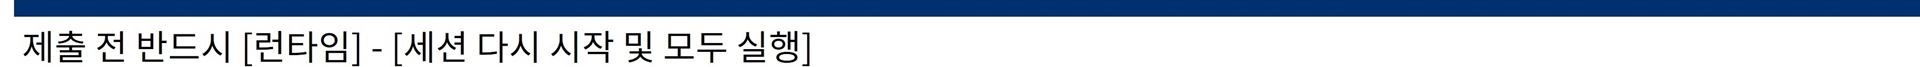

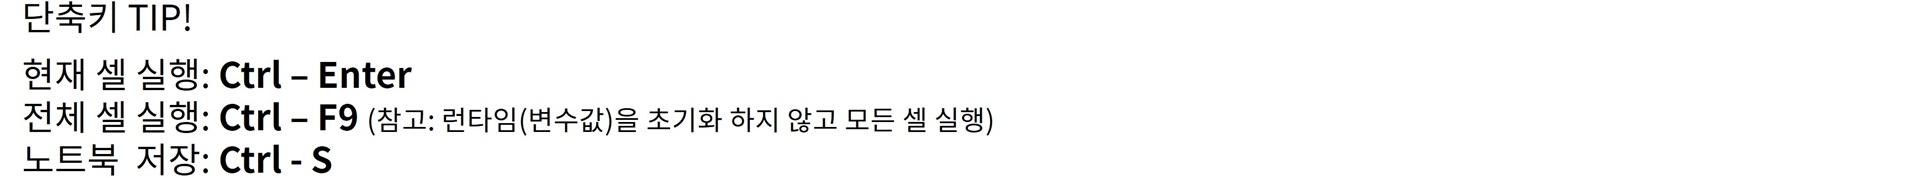